### Packages

In [1]:
import os
from IPython.display import display
import folium 
import mapclassify
import pickle
import time
import math
from esda.moran import Moran
from libpysal.weights import Queen, KNN, W
import seaborn as sb
import pandas as pd
import geopandas as gpd
import numpy as np
from scipy import stats
from scipy.stats import kruskal, pearsonr, spearmanr
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from clustergram import Clustergram
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
import scikit_posthocs as sp
from sklearn import metrics
from scipy.spatial.distance import cdist
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

<string>:1: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).


### Data

In [2]:
# load the clustergram
with open('clustergram_kmeans_pca.pickle','rb') as f:
    cgram_kmeans_pca = pickle.load(f)

In [3]:
# Importing health data geopackage
healthdata = gpd.read_file("Greater_Manchester_NH_GIS.gpkg")

In [66]:
# load the dataframe
with open('popgridsub.pkl','rb') as f:
    popgridsub = pickle.load(f)

In [5]:
# load the PCA dataframe
with open('popgridsub_pca.pkl','rb') as f:
    df_pca = pickle.load(f)

In [3]:
# Main gdf
popgridmanchester = gpd.read_file("popgridmanchesterlatest.gpkg")

# Converting population/building density to per km^2, will do this for the main gdf
popgridmanchester.buffer_pop_density = popgridmanchester.buffer_pop_density*1000000
popgridmanchester.building_density = popgridmanchester.building_density*1000000

# Subset of variables of interest
popgridsub = popgridmanchester.iloc[:,[4,11,18,21,22,25,27,30,31]+list(range(36,60))]

# Remove nans and inf values, resetting index, saving
popgridsub = popgridsub.replace([np.inf, -np.inf], np.nan)
popgridsub = popgridsub.dropna()
popgridsub = popgridsub.reset_index()
popgridsub = popgridsub.drop(columns=['index'])
popgridsub.to_pickle("popgridsub.pkl")

c:\Users\Gebruiker\anaconda3\envs\ssml\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [6]:
# Variables of interest
cluster_variables = [col for col in popgridsub.columns if col != "geometry"]

# Scaling due to the range of values differing between variables
scaler = StandardScaler()
popgridsub_scaled = scaler.fit_transform(popgridsub[cluster_variables])

# Convert to df
popgridsub_scaled_df = pd.DataFrame(popgridsub_scaled, columns=cluster_variables)

### Spatial autocorrelation test with Moran's I

In [9]:
# Creating a weight matrix with Queen's contiguity
w = Queen.from_dataframe(popgridsub)

c:\Users\Gebruiker\anaconda3\envs\ssml\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 70 disconnected components.
 There are 47 islands with ids: 4045, 4095, 5703, 5704, 5882, 14861, 20797, 21388, 27472, 30944, 41978, 54220, 84793, 104667, 116169, 141226, 141245, 149285, 150774, 164917, 174411, 198750, 202226, 206597, 208610, 212539, 217362, 246590, 270528, 277947, 281715, 287499, 290436, 291223, 292693, 293925, 293928, 294156, 295182, 297722, 297793, 297824, 297826, 297827, 297866, 303168, 307808.
  warnings.warn(message)


In [10]:
# Moran's I for each scaled variable
mi_results = [
    Moran(popgridsub[variable], w) for variable in cluster_variables
]
# Structure results as a list of tuples
mi_results = [
    (variable, res.I, res.p_sim)
    for variable, res in zip(cluster_variables, mi_results)
]
# Display on table
table = pd.DataFrame(
    mi_results, columns=["Variable", "Moran's I", "P-value"]
).set_index("Variable")
table

('WARNING: ', 4045, ' is an island (no neighbors)')
('WARNING: ', 4095, ' is an island (no neighbors)')
('WARNING: ', 5703, ' is an island (no neighbors)')
('WARNING: ', 5704, ' is an island (no neighbors)')
('WARNING: ', 5882, ' is an island (no neighbors)')
('WARNING: ', 14861, ' is an island (no neighbors)')
('WARNING: ', 20797, ' is an island (no neighbors)')
('WARNING: ', 21388, ' is an island (no neighbors)')
('WARNING: ', 27472, ' is an island (no neighbors)')
('WARNING: ', 30944, ' is an island (no neighbors)')
('WARNING: ', 41978, ' is an island (no neighbors)')
('WARNING: ', 54220, ' is an island (no neighbors)')
('WARNING: ', 84793, ' is an island (no neighbors)')
('WARNING: ', 104667, ' is an island (no neighbors)')
('WARNING: ', 116169, ' is an island (no neighbors)')
('WARNING: ', 141226, ' is an island (no neighbors)')
('WARNING: ', 141245, ' is an island (no neighbors)')
('WARNING: ', 149285, ' is an island (no neighbors)')
('WARNING: ', 150774, ' is an island (no neigh

,Moran's I,P-value
Variable,,
population,0.769731,0.001
buffer_pop_density,0.984706,0.001
intersection_count,0.994120,0.001
street_length_avg,0.912215,0.001
circuity_avg,0.633191,0.001
intersection_density_km,0.044017,0.001
street_density_km,0.010956,0.001
streets_per_node_counts.2,0.952675,0.001
streets_per_node_counts.3,0.993912,0.001


### Principal Component Analysis for dimension reduction

<AxesSubplot: >

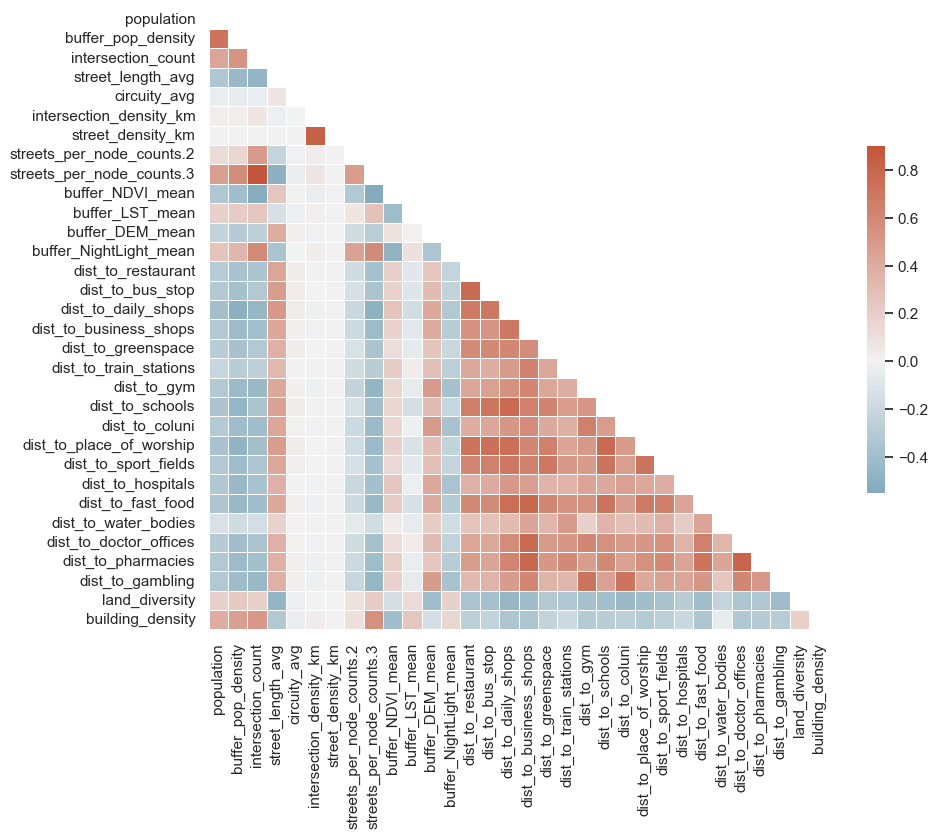

In [11]:
# Correlations to determine multicollinearity between the cluster variables before PCA
sb.set_theme(style="white")

# Compute the correlation matrix
corr = popgridsub_scaled_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 9))

# Generate a custom diverging colormap
cmap = sb.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sb.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

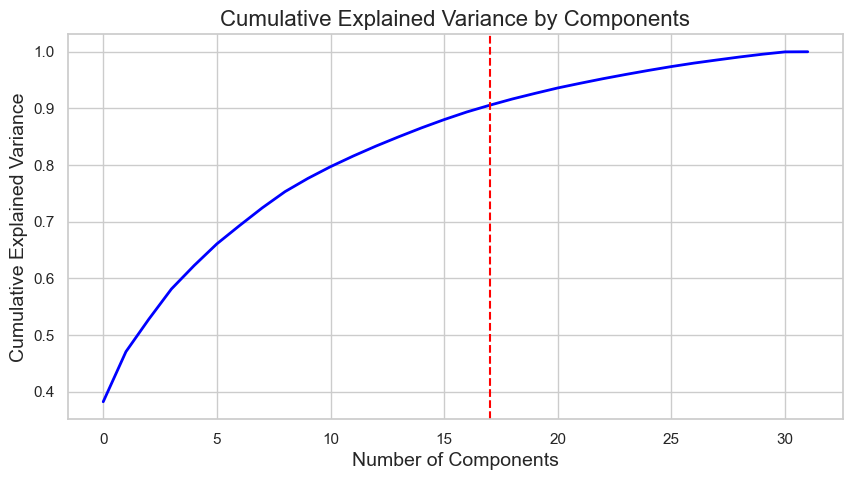

In [15]:
# Dimension reduction with PCA
pca = PCA(n_components=len(popgridsub[cluster_variables].columns))
principal_components = pca.fit_transform(popgridsub_scaled_df)

# Plot to determine the amount of components
plt.figure(figsize=(10,5))
sb.set(style='whitegrid')
plt.plot(np.cumsum(pca.explained_variance_ratio_), linewidth=2, color='blue')
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Cumulative Explained Variance', fontsize=14)
plt.title('Cumulative Explained Variance by Components', fontsize=16)
plt.grid(True)

# Vertical line intersecting at the 90% cumulative explained variance 
plt.axvline(np.where(np.cumsum(pca.explained_variance_ratio_)>= 0.9)[0][0], 
            color='red', linestyle='--')

# Save figure 
plt.savefig("cumulexpPCA.png")

plt.show()

In [16]:
# Model where 90% of variance is retained 
pca = PCA(n_components=0.90)
principal_components = pca.fit_transform(popgridsub_scaled_df)

# Principal components dataframe, convert to geodataframe, add geometry column
df_pca = pd.DataFrame(data = principal_components, columns = ['PC'+str(i) for i in range(1, len(pca.components_)+1)])

In [17]:
# Saving df
df_pca.to_pickle("popgridsub_pca.pkl")

In [18]:
# Plot the loadings from 0.2 for each of the components

for i, component in enumerate(pca.components_, start=1):
    loadings = pd.DataFrame(component, index=popgridsub[cluster_variables].columns, columns=['loading'])
    significant_loadings = loadings[loadings['loading'].abs() >= 0.2]
    print(f"Component {i}:")
    print(significant_loadings)
    print("\n")

Component 1:
                           loading
dist_to_restaurant        0.203172
dist_to_bus_stop          0.207118
dist_to_daily_shops       0.242948
dist_to_business_shops    0.237295
dist_to_gym               0.206930
dist_to_schools           0.228148
dist_to_place_of_worship  0.227924
dist_to_sport_fields      0.219273
dist_to_fast_food         0.235808
dist_to_doctor_offices    0.210132
dist_to_pharmacies        0.217561


Component 2:
                            loading
intersection_count         0.371360
streets_per_node_counts.2  0.256560
streets_per_node_counts.3  0.366579
buffer_NDVI_mean          -0.374606
buffer_LST_mean            0.224083
buffer_NightLight_mean     0.287866
building_density           0.224216


Component 3:
                          loading
intersection_density_km  0.702798
street_density_km        0.705924


Component 4:
                           loading
buffer_LST_mean          -0.311069
buffer_DEM_mean          -0.353639
buffer_NightLight_mean    0

### Gaussian mixture model with clustergram

In [97]:
# Using clustergram with GMM clustering up to 20 clusters
cgram_kmeans_pca = Clustergram(range(2, 21), method='kmeans')

start_time = time.time()

#fit model
cgram_kmeans_pca.fit(df_pca)

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

K=2 fitted in 4.712390422821045 seconds.
K=3 fitted in 12.082188129425049 seconds.
K=4 fitted in 15.575828313827515 seconds.
K=5 fitted in 12.184971570968628 seconds.
K=6 fitted in 52.314653635025024 seconds.
K=7 fitted in 99.03813695907593 seconds.
K=8 fitted in 38.35846567153931 seconds.
K=9 fitted in 51.39904856681824 seconds.
K=10 fitted in 122.05049896240234 seconds.
K=11 fitted in 184.9095435142517 seconds.
K=12 fitted in 170.39475846290588 seconds.
K=13 fitted in 124.32994532585144 seconds.
K=14 fitted in 126.8499367237091 seconds.
K=15 fitted in 210.2267677783966 seconds.
K=16 fitted in 139.1791911125183 seconds.
K=17 fitted in 136.183354139328 seconds.
K=18 fitted in 164.7120292186737 seconds.
K=19 fitted in 400.42809796333313 seconds.
K=20 fitted in 260.22873711586 seconds.
Execution time: 2325.1784908771515 seconds


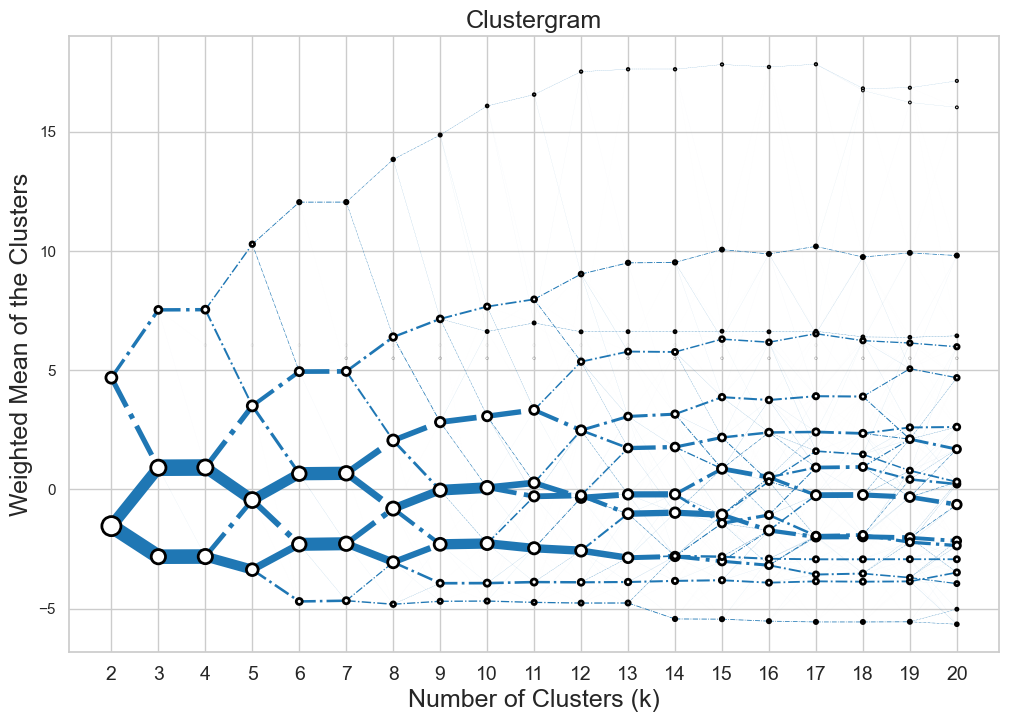

In [7]:
# plot cgram
sb.set(style='whitegrid')

cgram_kmeans_pca.plot(
    size=0.5,
    linewidth=0.5,
    cluster_style={"color": "white", "edgecolor": "black"},
    line_style={"color": "tab:blue", "linestyle": "-."},
    figsize=(12, 8),
)

# Set x-axis to display only integers and adjust fontsize
plt.xticks(range(2,21), fontsize=14)
plt.xlabel('Number of Clusters (k)', fontsize=18)
plt.ylabel('Weighted Mean of the Clusters', fontsize=18)
plt.title("Clustergram", fontsize=18)

# Save figure
plt.savefig("clustergram_kmeans.png")

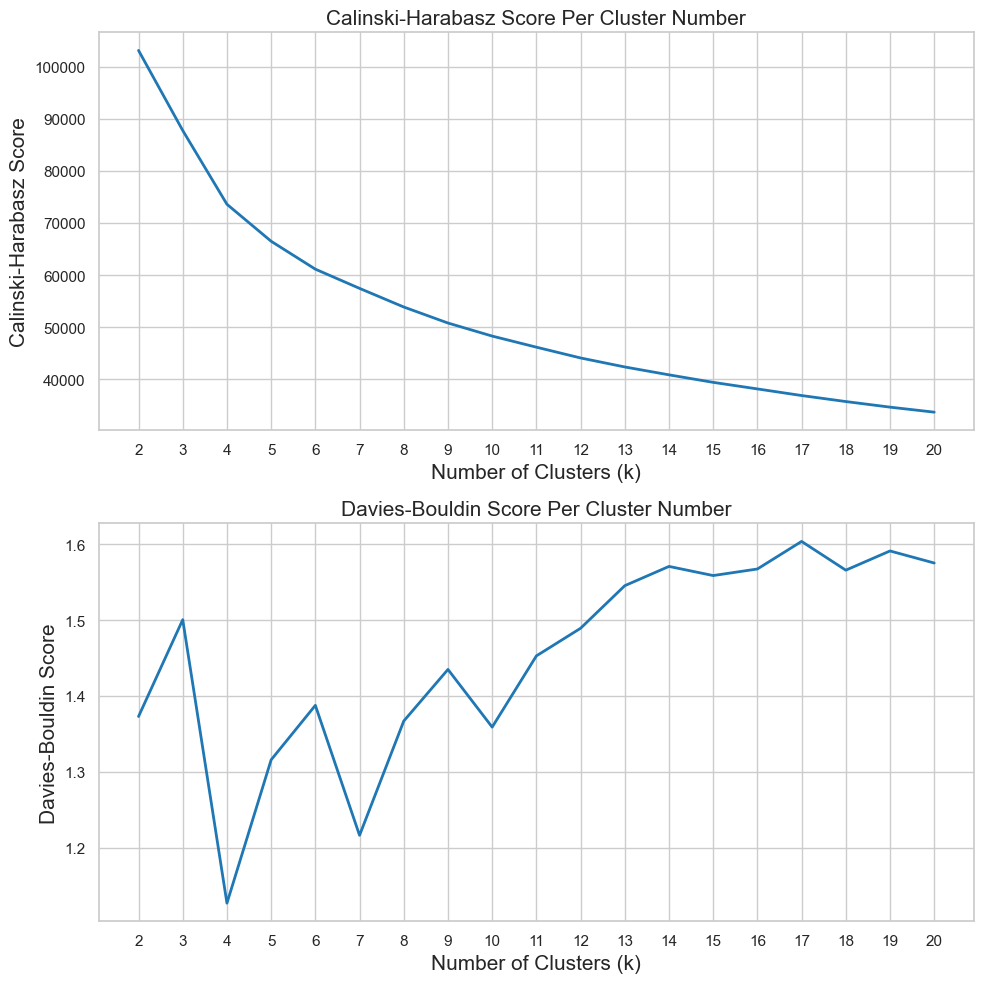

In [8]:
# Goodness of fit tests for the amount of clusters
# We use the Davies-Bouldin and Calinski-Harabasz scores, higher is better for both

# Calinski-Harabasz score: the within-cluster variance divided by the between-cluster variance.
# Davies-Bouldin score: The score is defined as the average similarity measure of each cluster with its most similar cluster, 
#  where similarity is the ratio of within-cluster distances to between-cluster distances. 
#  Thus, clusters which are farther apart and less dispersed will result in a better score.

# Range for cluster number
K = range(2,21)

# getting the scores
kmeansch_pca = cgram_kmeans_pca.calinski_harabasz_score()
kmeansdb_pca = cgram_kmeans_pca.davies_bouldin_score()

# Plotting both the Davies-Bouldin score and the Calinski-Harabasz score per cluster amount
fig, axs = plt.subplots(2, figsize=(10, 10))

# Plot Calinski-Harabasz score
axs[0].plot(K, kmeansch_pca, linewidth=2, color='tab:blue')
axs[0].set_xlabel("Number of Clusters (k)", fontsize=15)
axs[0].set_ylabel("Calinski-Harabasz Score", fontsize=15)
axs[0].tick_params(axis='y')
axs[0].grid(True)
axs[0].set_xticks(range(2,21))
axs[0].set_title('Calinski-Harabasz Score Per Cluster Number', fontsize=15)

# Plot Davies-Bouldin score
color = 'tab:red'
axs[1].plot(K, kmeansdb_pca, linewidth=2, color='tab:blue')
axs[1].set_xlabel("Number of Clusters (k)", fontsize=15)
axs[1].set_ylabel("Davies-Bouldin Score", fontsize=15)
axs[1].tick_params(axis='y')
axs[1].grid(True)
axs[1].set_xticks(range(2,21))
axs[1].set_title('Davies-Bouldin Score Per Cluster Number', fontsize=15)
plt.tight_layout()
plt.show()

# Save figure
fig.savefig("kmeans_perf.png")

In [34]:
# saving clustergram
with open('clustergram_kmeans_pca.pickle','wb') as f:
    pickle.dump(cgram_kmeans_pca, f)

### Clustermap with 8 Clusters

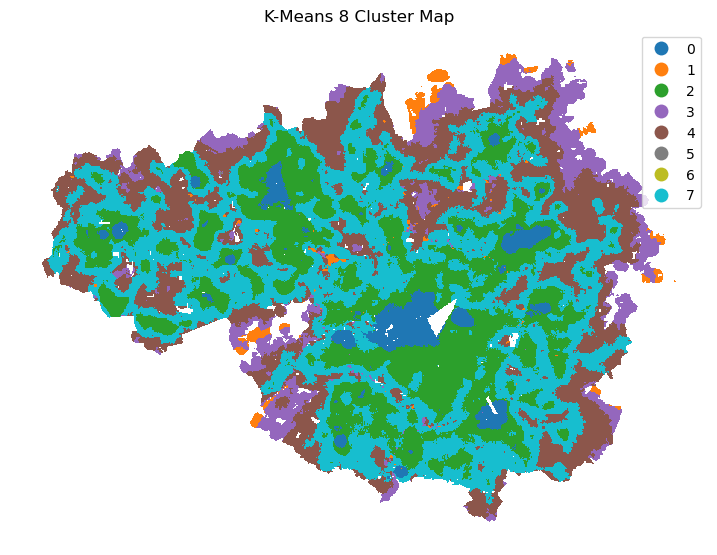

In [8]:
# Plotting results, 8 clusters
popgridsub["Kmeans_cluster_label8"] = cgram_kmeans_pca.labels[8]
# Set up figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
popgridsub.plot(
    column="Kmeans_cluster_label8",
    categorical=True,
    legend=True,
    linewidth=0,
    ax=ax,
)
# Remove axis
ax.set_axis_off()

# Display the map
plt.title("K-Means 8 Cluster Map")
plt.show()

In [9]:
# subset of popgridsub to only contain the cluster labels and geometry
popgridsub8 = popgridsub[["Kmeans_cluster_label8", "geometry"]]

In [59]:
# subset of popgridsub to only contain the relevant health variables
mentalhealth8 = healthdata[["ID", "Yrpotlife", "Comilldis", "Income_Sco", "Older_popu", "Pop_mid", "geometry"]]
mentalhealth8 = mentalhealth8.rename(columns={'Yrpotlife': 'Premature Deaths', 
                                              'Comilldis': 'Comparative Illness and Disability',
                                              'Income_Sco': 'Income Deprivation'})
mentalhealth8["Ratio of Older Adults"] = mentalhealth8["Older_popu"] / mentalhealth8["Pop_mid"]
mentalhealth8.drop(["Older_popu", "Pop_mid"], axis=1, inplace=True)

In [60]:
# spatial join
joined_data8 = gpd.sjoin(mentalhealth8, popgridsub8, how='inner', predicate='intersects')

# calculating the most common cluster label for each neighborhood and for both cluster models
majority_cluster_kmeans8 = joined_data8.groupby('ID')['Kmeans_cluster_label8'].apply(lambda x: x.mode())

# calculating the diversity of the labels using Shannon entropy
def calculate_entropy(labels):
    unique_labels, label_counts = np.unique(labels, return_counts=True)
    proportions = label_counts / label_counts.sum()
    entropy = -np.sum(proportions * np.log2(proportions))
    return entropy

# apply function
cluster_diversity_kmeans8 = joined_data8.groupby('ID')['Kmeans_cluster_label8'].apply(calculate_entropy)

# merging the cluster majority and cluster diversity
mentalhealth8 = mentalhealth8.merge(majority_cluster_kmeans8, on='ID')
mentalhealth8 = mentalhealth8.merge(cluster_diversity_kmeans8, on='ID')

# renaming
mentalhealth8 = mentalhealth8.rename(columns={'Kmeans_cluster_label8_x': 'Majority Cluster', 'Kmeans_cluster_label8_y': 'Cluster Diversity'})

In [61]:
# checking data
mentalhealth8.head(5)

,ID,Premature Deaths,Comparative Illness and Disability,Income Deprivation,geometry,Ratio of Older Adults,Majority Cluster,Cluster Diversity
0,1,73.298,139.960,0.171,"MULTIPOLYGON (((371172.854 411677.763, 371171....",0.434736,2,0.969456
1,2,70.453,122.767,0.129,"MULTIPOLYGON (((371710.608 411870.891, 371719....",0.370829,2,0.751808
2,3,60.683,87.251,0.033,"MULTIPOLYGON (((371146.001 413306.000, 371154....",0.415094,4,1.520471
3,4,66.842,101.857,0.046,"MULTIPOLYGON (((371628.421 413041.967, 371623....",0.468787,2,-0.000000
4,5,59.963,96.842,0.061,"MULTIPOLYGON (((372209.845 412244.211, 372253....",0.636488,2,0.766691


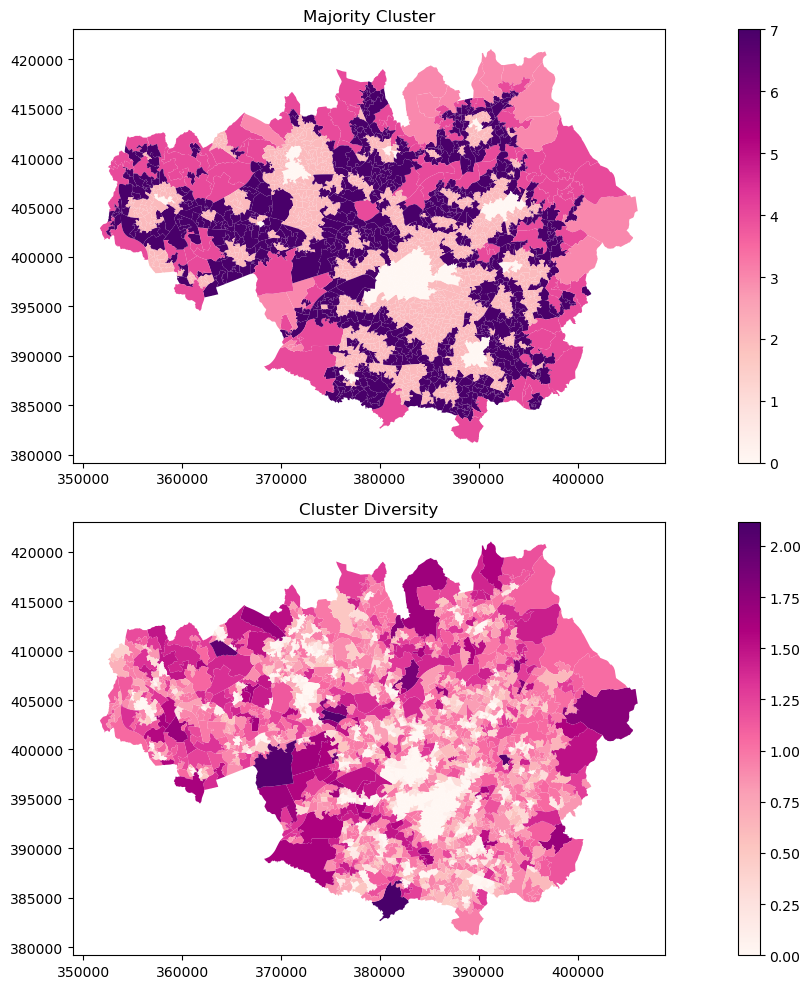

In [13]:
# Plotting the majority and diversity variables
fig, axs = plt.subplots(2, figsize=(15,10))
mentalhealth8.plot(column='Majority Cluster', ax=axs[0],
        linewidth=0,
        cmap="RdPu",
        legend=True)
axs[0].set_title("Majority Cluster")
mentalhealth8.plot(column='Cluster Diversity', ax=axs[1],
        linewidth=0,
        cmap="RdPu",
        legend=True)
axs[1].set_title("Cluster Diversity")
plt.tight_layout()

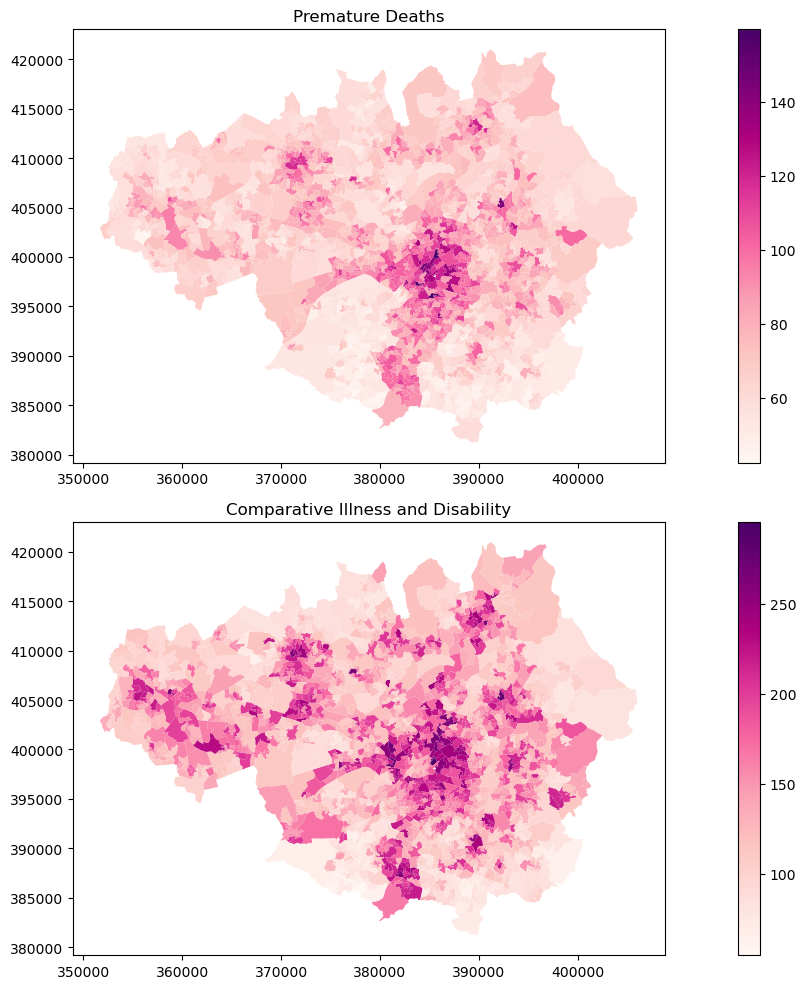

In [14]:
# Plotting health variables
fig, axs = plt.subplots(2, figsize=(15,10))
mentalhealth8.plot(column='Premature Deaths', ax=axs[0],
        linewidth=0,
        cmap="RdPu",
        legend=True)
axs[0].set_title("Premature Deaths")
mentalhealth8.plot(column='Comparative Illness and Disability', ax=axs[1],
        linewidth=0,
        cmap="RdPu",
        legend=True)
axs[1].set_title("Comparative Illness and Disability")

plt.tight_layout()

### Income and Age per Cluster

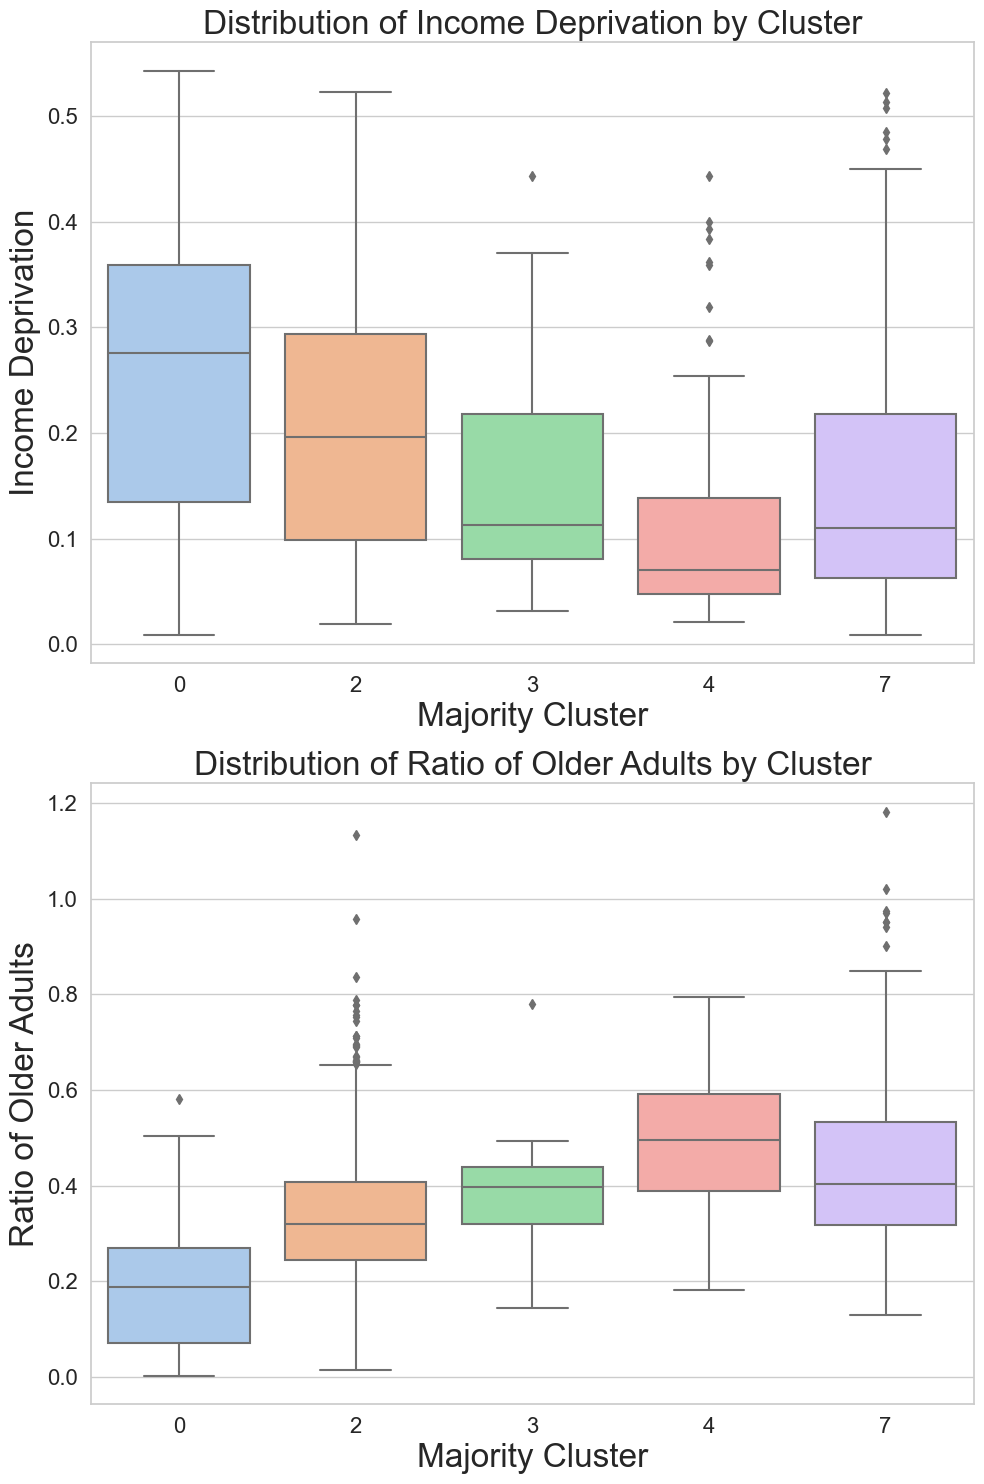

In [84]:
# boxplots to show the distributions of the mental health variables per cluster majority value

# health outcomes
variables = ["Income Deprivation",
             "Ratio of Older Adults"]

# Set the style and color palette
sb.set(style='whitegrid')
colors = sb.color_palette('pastel')[0:len(mentalhealth8['Majority Cluster'].unique())]

fig, axs = plt.subplots(len(variables), figsize=(10, 15))

for i, x in enumerate(variables):
    # Create boxplot
    sb.boxplot(x='Majority Cluster', y=x, data=mentalhealth8, palette=colors, ax=axs[i])
    # Set title and labels with increased font size
    axs[i].set_title(f'Distribution of {x} by Cluster', fontsize=24)
    axs[i].set_xlabel('Majority Cluster', fontsize=24)
    axs[i].set_ylabel(x, fontsize=24)
    # Increase tick label size
    axs[i].tick_params(labelsize=16)

# Adjust the overall title and layout
plt.tight_layout()
plt.show()
fig.savefig("incomeage.png")

### Mental Health per Cluster

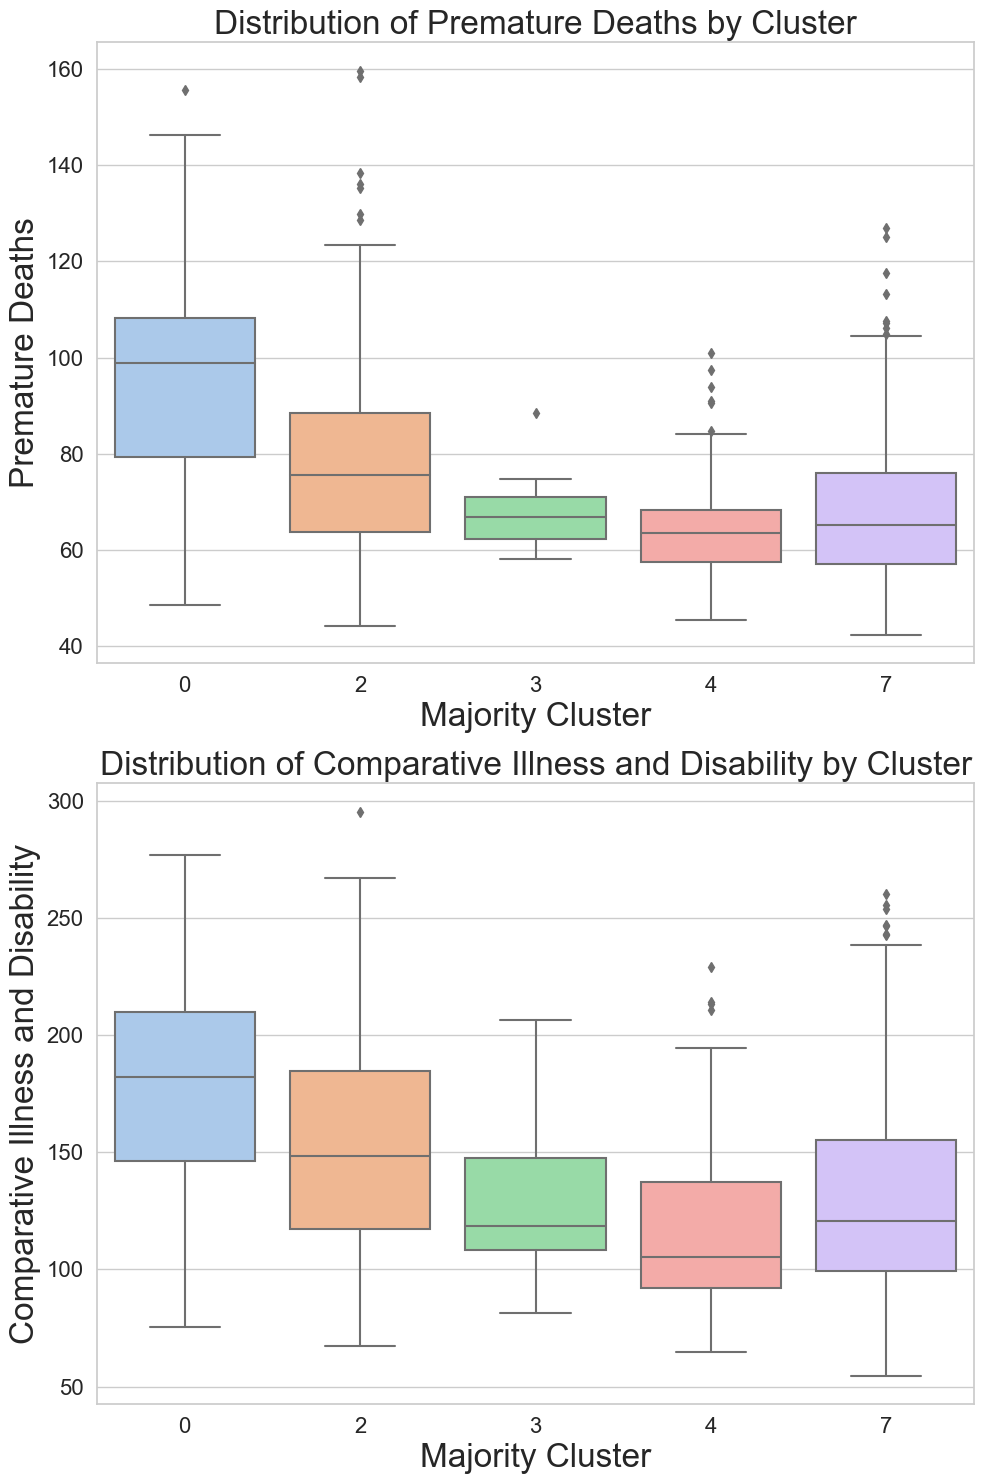

In [16]:
# boxplots to show the distributions of the mental health variables per cluster majority value

# health outcomes
health_outcomes = ["Premature Deaths",
                   "Comparative Illness and Disability"]

# Set the style and color palette
sb.set(style='whitegrid')
colors = sb.color_palette('pastel')[0:len(mentalhealth8['Majority Cluster'].unique())]

fig, axs = plt.subplots(len(health_outcomes), figsize=(10, 15))

for i, x in enumerate(health_outcomes):
    # Create boxplot
    sb.boxplot(x='Majority Cluster', y=x, data=mentalhealth8, palette=colors, ax=axs[i])
    # Set title and labels with increased font size
    axs[i].set_title(f'Distribution of {x} by Cluster', fontsize=24)
    axs[i].set_xlabel('Majority Cluster', fontsize=24)
    axs[i].set_ylabel(x, fontsize=24)
    # Increase tick label size
    axs[i].tick_params(labelsize=16)

# Adjust the overall title and layout
plt.tight_layout()
plt.show()
fig.savefig("boxplots.png")

In [17]:
# kruskal-wallis test for the cluster majority variable to see if the distributions 
# of the health outcomes differ for each cluster majority value

# grouped variable
clustermajority_kmeans8 = mentalhealth8.groupby('Majority Cluster')

# kruskal-wallis test for each of the health variables with the cluster majority variable
for x in health_outcomes:
    # for each cluster (K-means)
    data = [group[x].values for _, group in clustermajority_kmeans8]
    # kruskal-wallis test
    stat, p = kruskal(*data)
    print(f'Variable: {x}')
    print(f'Statistics: {stat}')
    print(f'P-value: {p}\n')

Variable: Premature Deaths
Statistics: 249.76824157516816
P-value: 7.302749700998093e-53

Variable: Comparative Illness and Disability
Statistics: 208.33031688646994
P-value: 6.07460945820314e-44



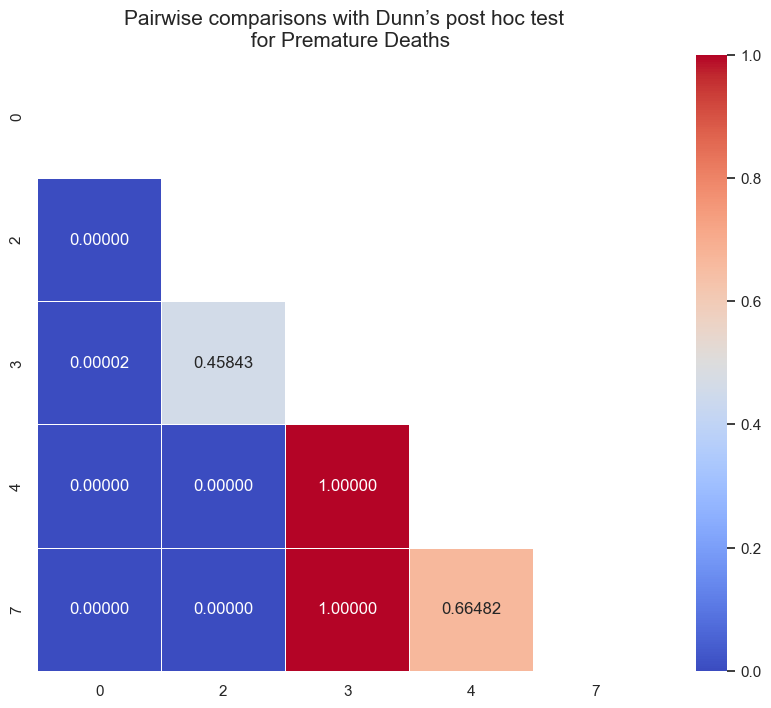

In [18]:
# Dunn's test for pairwise comparisons for each of the majority cluster labels
# for Depression prevalence

posthoc = sp.posthoc_dunn(mentalhealth8, val_col='Premature Deaths', 
                          group_col='Majority Cluster', p_adjust='bonferroni')

# Mask the upper triangle
mask = np.triu(np.ones_like(posthoc, dtype=bool))

# Create a heatmap
plt.figure(figsize=(10, 8))
sb.heatmap(posthoc, mask=mask, cmap='coolwarm', annot=True, fmt=".5f", linewidths=.5)
plt.title('Pairwise comparisons with Dunn’s post hoc test \n for Premature Deaths', fontsize=15)
plt.show()

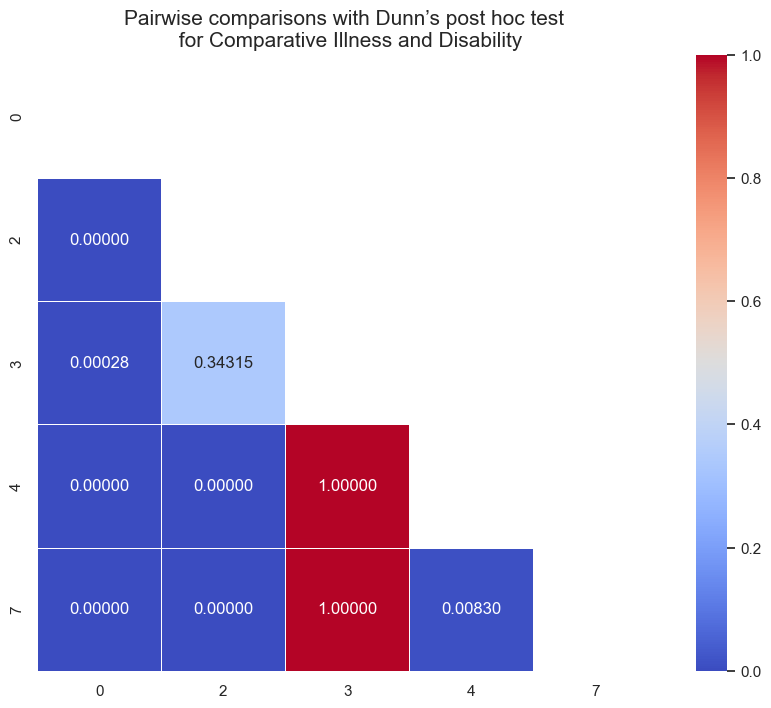

In [19]:
# Dunn's test for pairwise comparisons for each of the majority cluster labels
# for Depression prevalence

posthoc = sp.posthoc_dunn(mentalhealth8, val_col='Comparative Illness and Disability', 
                          group_col='Majority Cluster', p_adjust='bonferroni')

# Mask the upper triangle
mask = np.triu(np.ones_like(posthoc, dtype=bool))

# Create a heatmap
plt.figure(figsize=(10, 8))
sb.heatmap(posthoc, mask=mask, cmap='coolwarm', annot=True, fmt=".5f", linewidths=.5)
plt.title('Pairwise comparisons with Dunn’s post hoc test \n for Comparative Illness and Disability', fontsize=15)
plt.show()

### Transforming Majority Cluster into a Likert Scale of 0, 1, 2, 3 for Spearman Correlations

For 'Cluster Premature Deaths':
- Cluster 3, 7, and 4 become 1 as they represent good mortality and morbidity
- Cluster 2 remains 2 as it represents moderate mortality and morbidity
- Cluster 0 becomes 3 since it represents poor mortality and morbidity

For 'Comparative Illness and Disability':
- Cluster 4 becomes 0 as it represents very excellent mortality and morbidity
- Cluster 3 and 7 become 1 as they represent good mortality and morbidity
- Cluster 2 remains 2 as it represents moderate mortality and morbidity
- Cluster 0 becomes 3 since it represents poor mortality and morbidity

In [20]:
# Creating a likert scale from the Majority cluster variable, since there seems to be an order
cluster_order_death = {0:3, 2:2, 3:1, 7:1, 4:1}
mentalhealth8['Ordinal Majority Cluster Premature Deaths'] = mentalhealth8['Majority Cluster'].replace(cluster_order_death)

In [21]:
# Creating a likert scale from the Majority cluster variable, since there seems to be an order
cluster_order_illness = {0:3, 2:2, 3:1, 7:1, 4:0}
mentalhealth8['Ordinal Majority Cluster Comparative Illness and Disability'] = mentalhealth8['Majority Cluster'].replace(cluster_order_illness)

In [89]:
# Save as geodataframe
mentalhealth8.to_file("mentalhealthsubset.gpkg", driver="GPKG")

In [22]:
mentalhealth8.head()

,ID,Premature Deaths,Comparative Illness and Disability,Income Deprivation,geometry,Ratio of Older Adults,Majority Cluster,Cluster Diversity,Ordinal Majority Cluster Premature Deaths,Ordinal Majority Cluster Comparative Illness and Disability
0,1,73.298,139.960,0.171,"MULTIPOLYGON (((371172.854 411677.763, 371171....",0.434736,2,0.969456,2,2
1,2,70.453,122.767,0.129,"MULTIPOLYGON (((371710.608 411870.891, 371719....",0.370829,2,0.751808,2,2
2,3,60.683,87.251,0.033,"MULTIPOLYGON (((371146.001 413306.000, 371154....",0.415094,4,1.520471,1,0
3,4,66.842,101.857,0.046,"MULTIPOLYGON (((371628.421 413041.967, 371623....",0.468787,2,-0.000000,2,2
4,5,59.963,96.842,0.061,"MULTIPOLYGON (((372209.845 412244.211, 372253....",0.636488,2,0.766691,2,2


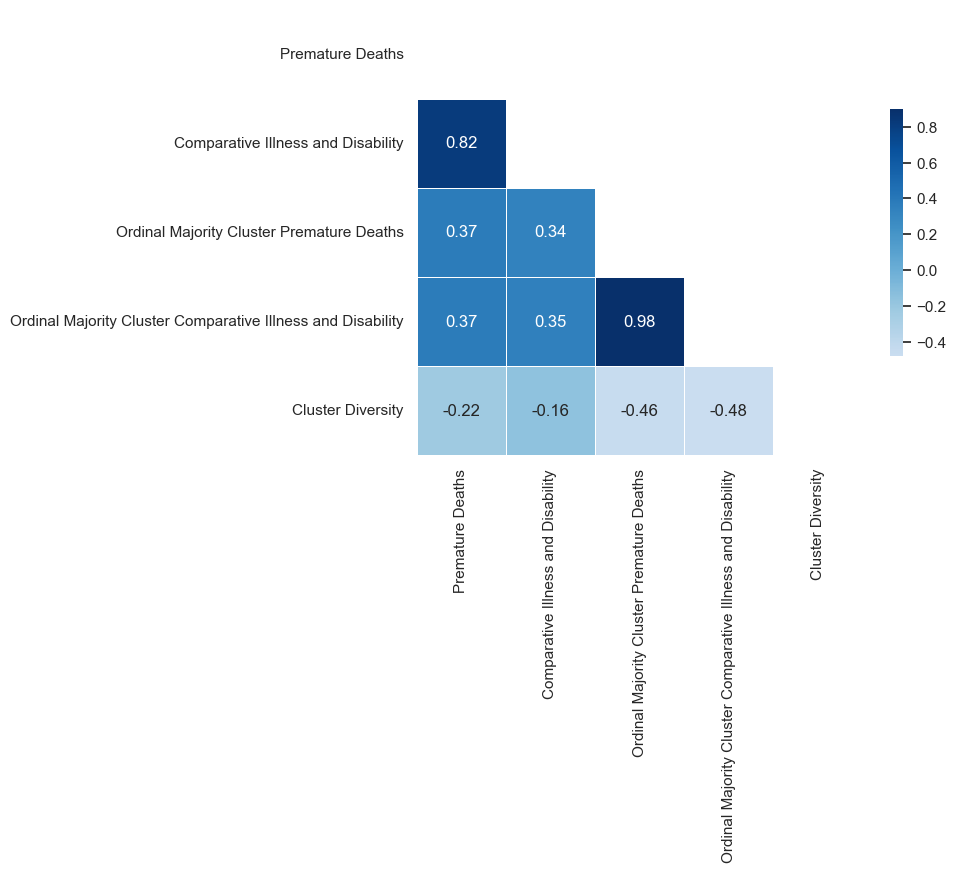

In [23]:
# Spearman correlation matrix of the variables 
sb.set_theme(style="white")

# Compute the correlation matrix
corr = mentalhealth8[["Premature Deaths",
                      "Comparative Illness and Disability",
                      "Ordinal Majority Cluster Premature Deaths",
                      "Ordinal Majority Cluster Comparative Illness and Disability",
                      "Cluster Diversity"]].corr(method='spearman')

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 9))

# Draw the heatmap with the mask and correct aspect ratio
sb.heatmap(corr, mask=mask, cmap='Blues', vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

# Save figure
plt.tight_layout()
f.savefig("correlationplot.png")

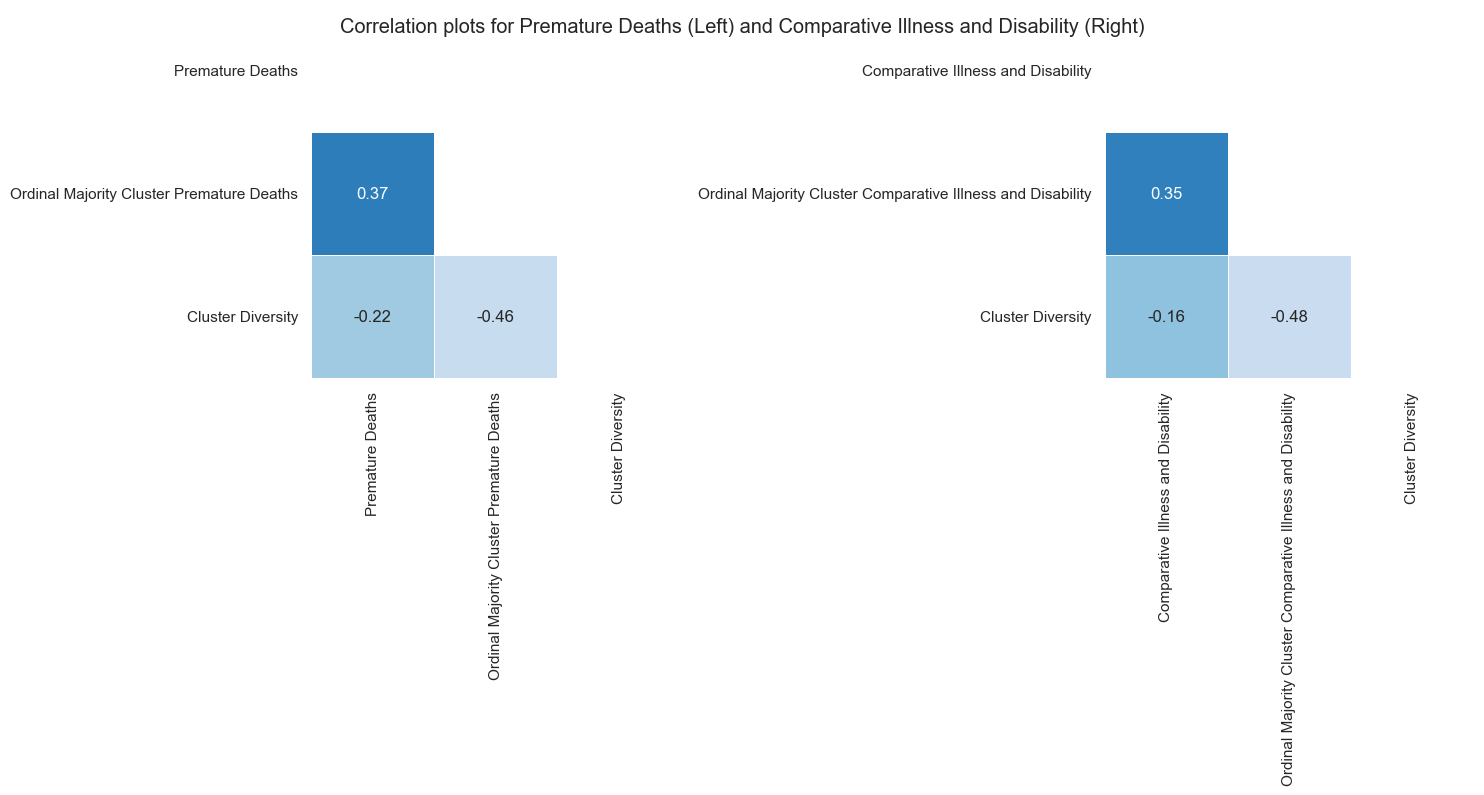

In [42]:
# Spearman correlation matrix of the variables 
sb.set_theme(style="white")

# Compute the correlation matrix
corr1 = mentalhealth8[["Premature Deaths",
                      "Ordinal Majority Cluster Premature Deaths",
                      "Cluster Diversity"]].corr(method='spearman')

# Compute the correlation matrix
corr2 = mentalhealth8[["Comparative Illness and Disability",
                      "Ordinal Majority Cluster Comparative Illness and Disability",
                      "Cluster Diversity"]].corr(method='spearman')

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr1, dtype=bool))

# Set up the matplotlib figure
f, axes = plt.subplots(1, 2, figsize=(15, 9))

# Make sure they don't overlap
plt.subplots_adjust(wspace=0.9)

# Draw the heatmap with the mask and correct aspect ratio
sb.heatmap(corr1, mask=mask, cmap='Blues', vmax=.9, center=0,
            square=True, linewidths=.5, cbar=False, annot=True, ax=axes[0])

# Draw the heatmap with the mask and correct aspect ratio
sb.heatmap(corr2, mask=mask, cmap='Blues', vmax=.9, center=0,
            square=True, linewidths=.5, cbar=False, annot=True, ax=axes[1])

plt.suptitle("Correlation plots for Premature Deaths (Left) and Comparative Illness and Disability (Right)", y=0.82)

# Save figure
plt.tight_layout()
f.savefig("correlationplot2.png")

In [44]:
# Significance tests
# Define the variables
variables = ["Premature Deaths",
             "Ordinal Majority Cluster Premature Deaths", 
             "Cluster Diversity"]

variables2 = ["Comparative Illness and Disability",
              "Ordinal Majority Cluster Comparative Illness and Disability", 
              "Cluster Diversity"]

# Initialize an empty DataFrame for the p-values
pval = pd.DataFrame(index=variables, columns=variables)

# Calculate the p-value for each pair of variables
for var1 in variables:
    print("\n")
    for var2 in variables:
        print(f'P-value for {var1} with {var2.ljust(30)}: {round(stats.spearmanr(mentalhealth8[var1], mentalhealth8[var2])[1], 4)}')

# Calculate the p-value for each pair of variables
for var1 in variables2:
    print("\n")
    for var2 in variables2:
        print(f'P-value for {var1} with {var2.ljust(30)}: {round(stats.spearmanr(mentalhealth8[var1], mentalhealth8[var2])[1], 4)}')



P-value for Premature Deaths with Premature Deaths              : 0.0
P-value for Premature Deaths with Ordinal Majority Cluster Premature Deaths: 0.0
P-value for Premature Deaths with Cluster Diversity             : 0.0


P-value for Ordinal Majority Cluster Premature Deaths with Premature Deaths              : 0.0
P-value for Ordinal Majority Cluster Premature Deaths with Ordinal Majority Cluster Premature Deaths: 0.0
P-value for Ordinal Majority Cluster Premature Deaths with Cluster Diversity             : 0.0


P-value for Cluster Diversity with Premature Deaths              : 0.0
P-value for Cluster Diversity with Ordinal Majority Cluster Premature Deaths: 0.0
P-value for Cluster Diversity with Cluster Diversity             : 0.0


P-value for Comparative Illness and Disability with Comparative Illness and Disability: 0.0
P-value for Comparative Illness and Disability with Ordinal Majority Cluster Comparative Illness and Disability: 0.0
P-value for Comparative Illness and Disabi

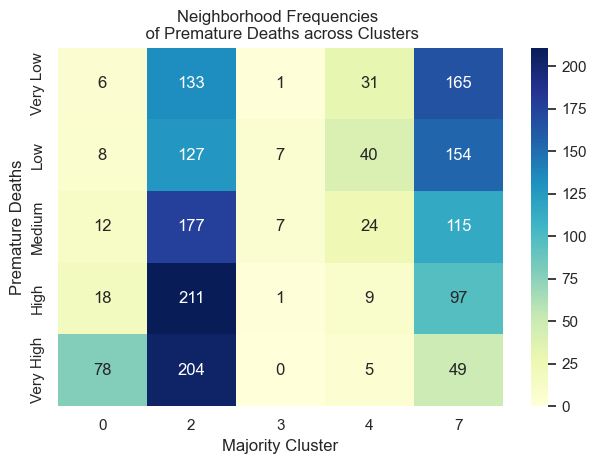

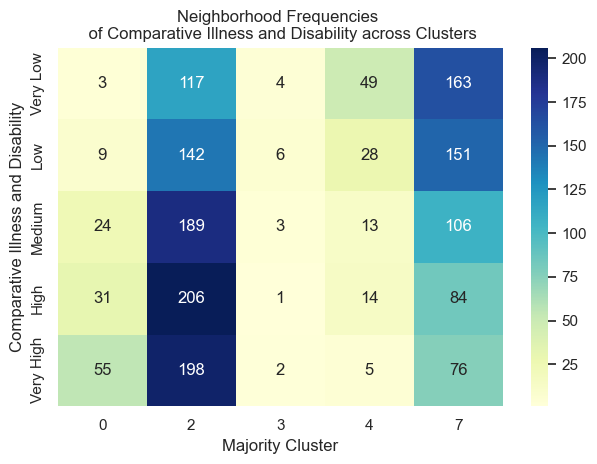

In [45]:
# contigency tables for further visualization of the cluster majority and health data relationship

# health variables
health_outcomes = ["Premature Deaths",
                   "Comparative Illness and Disability"]

# loop over the health outcomes to cut the health variables into 5 bins and create the contingency table
for x in health_outcomes:
    # cut into 5 bins
    mentalhealth8[f'{x}'] = pd.qcut(mentalhealth8[x], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
    # contingency table for the health outcome and cluster majority values
    contingency_table = pd.crosstab(mentalhealth8[f'{x}'], mentalhealth8['Majority Cluster'])
    sb.heatmap(contingency_table, annot=True, cmap='YlGnBu', fmt='.0f')
    plt.title(f"Neighborhood Frequencies \n of {x} across Clusters")
    plt.tight_layout()
    plt.savefig(f"{x}.png")
    plt.show()

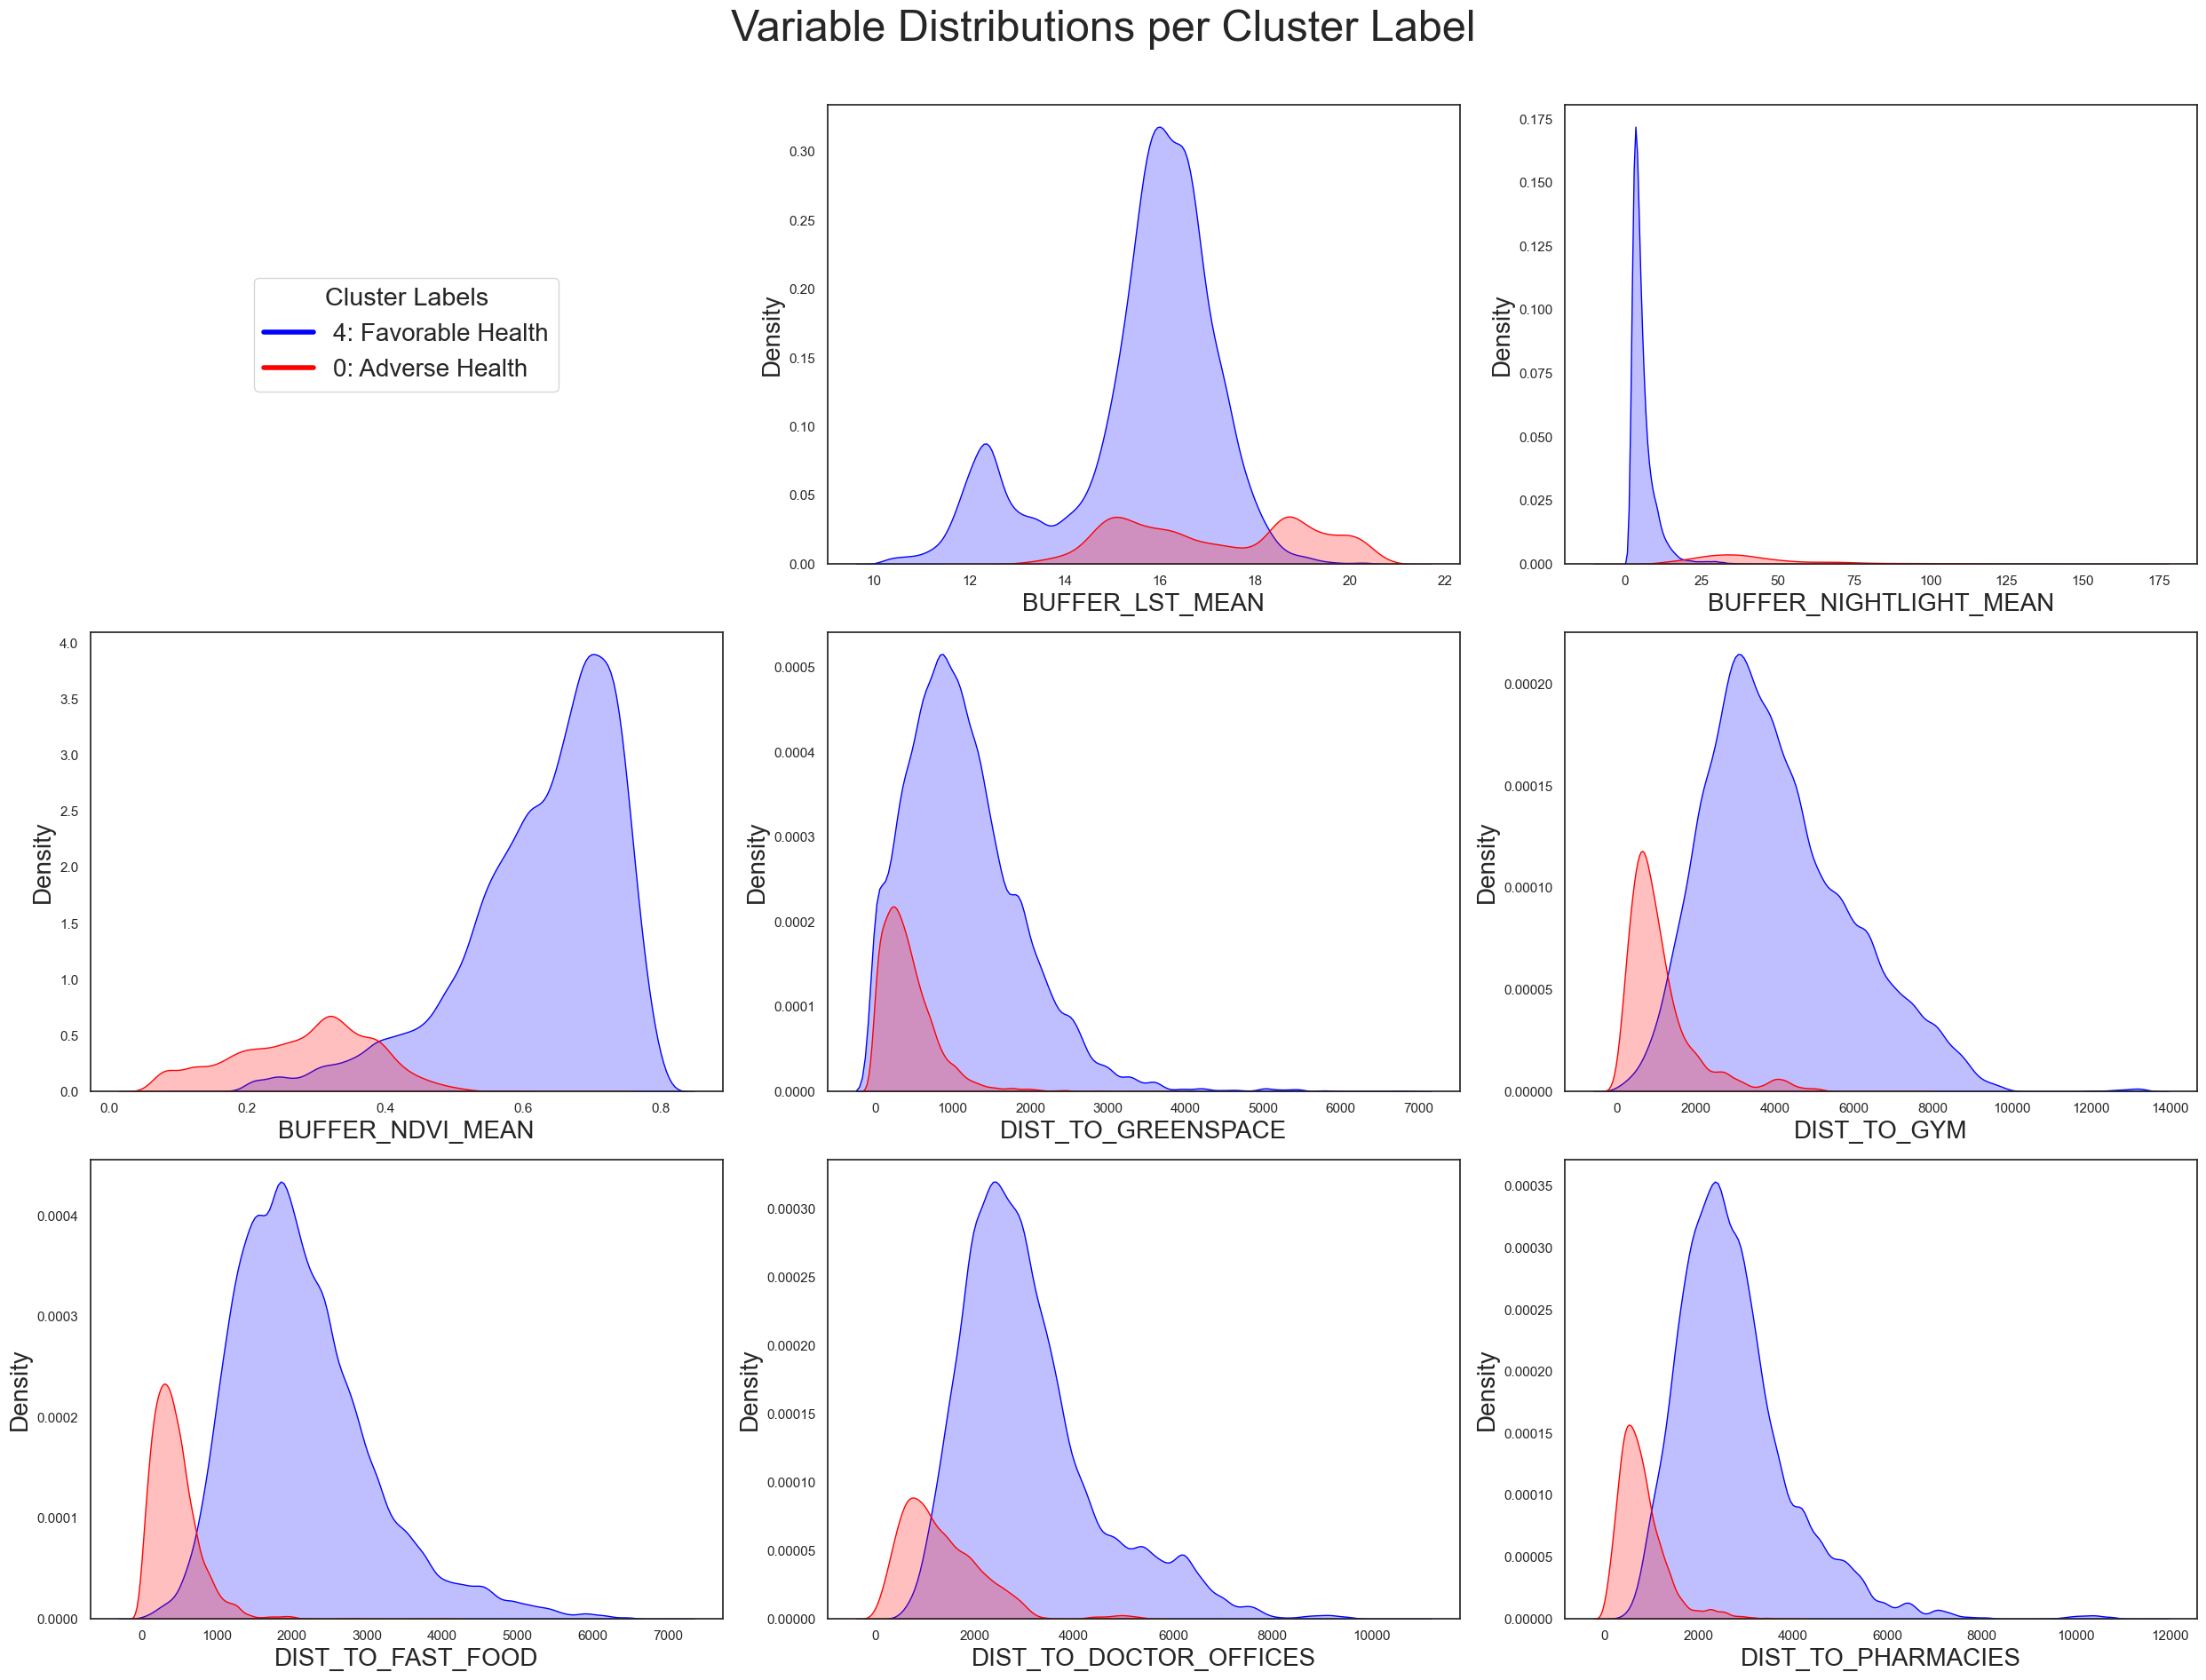

In [53]:
# checking distributions of the cluster variables within these clusters to see if
# they are high/low or normally distributed

# Street networks have been checked and are not useful to visualize

# cluster variables
variables = ['buffer_LST_mean', 'buffer_NightLight_mean', 'buffer_NDVI_mean',
             'dist_to_greenspace', 'dist_to_gym', 'dist_to_fast_food', 
             'dist_to_doctor_offices', 'dist_to_pharmacies']

# Filter the DataFrame for the desired cluster labels
kmeans_clusters = popgridsub[popgridsub['Kmeans_cluster_label8'].isin([4,0])]

# Number of rows and columns for subplot grid
n = len(variables)
ncols = 3
nrows = math.ceil(n / ncols)

# Create subplot grid
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(25, 18))

# Flatten axes for iteration
axes = axes.flatten()

# Empty plot for legend
ax = axes[0]
ax.axis('off')

# Create a legend with dummy lines for the first subplot
legend_elements = [Line2D([0], [0], color='blue', lw=4, label='4: Favorable Health'),
                   Line2D([0], [0], color='red', lw=4, label='0: Adverse Health')]
ax.legend(handles=legend_elements,
          loc='center', 
          title='Cluster Labels', 
          title_fontsize='xx-large', 
          fontsize=20)

# Make cluster 0 be blue and 3 red
color_dict = {4: "blue", 0: "red"}

# For each variable
for i, var in enumerate(variables, start=1):
    ax = axes[i]
    
    # Kernel density plots for each variable
    sb.kdeplot(data=kmeans_clusters, 
               x=var, 
               hue='Kmeans_cluster_label8', 
               fill=True, palette=color_dict, ax=ax, legend=False)
    ax.set_xlabel(f'{var.upper()}', fontsize=20)
    ax.set_ylabel("Density", fontsize=20)
    
# Remove empty subplots
for i in range(len(variables)+1, len(axes)):
    fig.delaxes(axes[i])
    
plt.tight_layout()
plt.suptitle("Variable Distributions per Cluster Label", y=1.05, fontsize=35)
plt.show()

# Save figure
fig.savefig("clustervardistfinal.png", bbox_inches='tight')

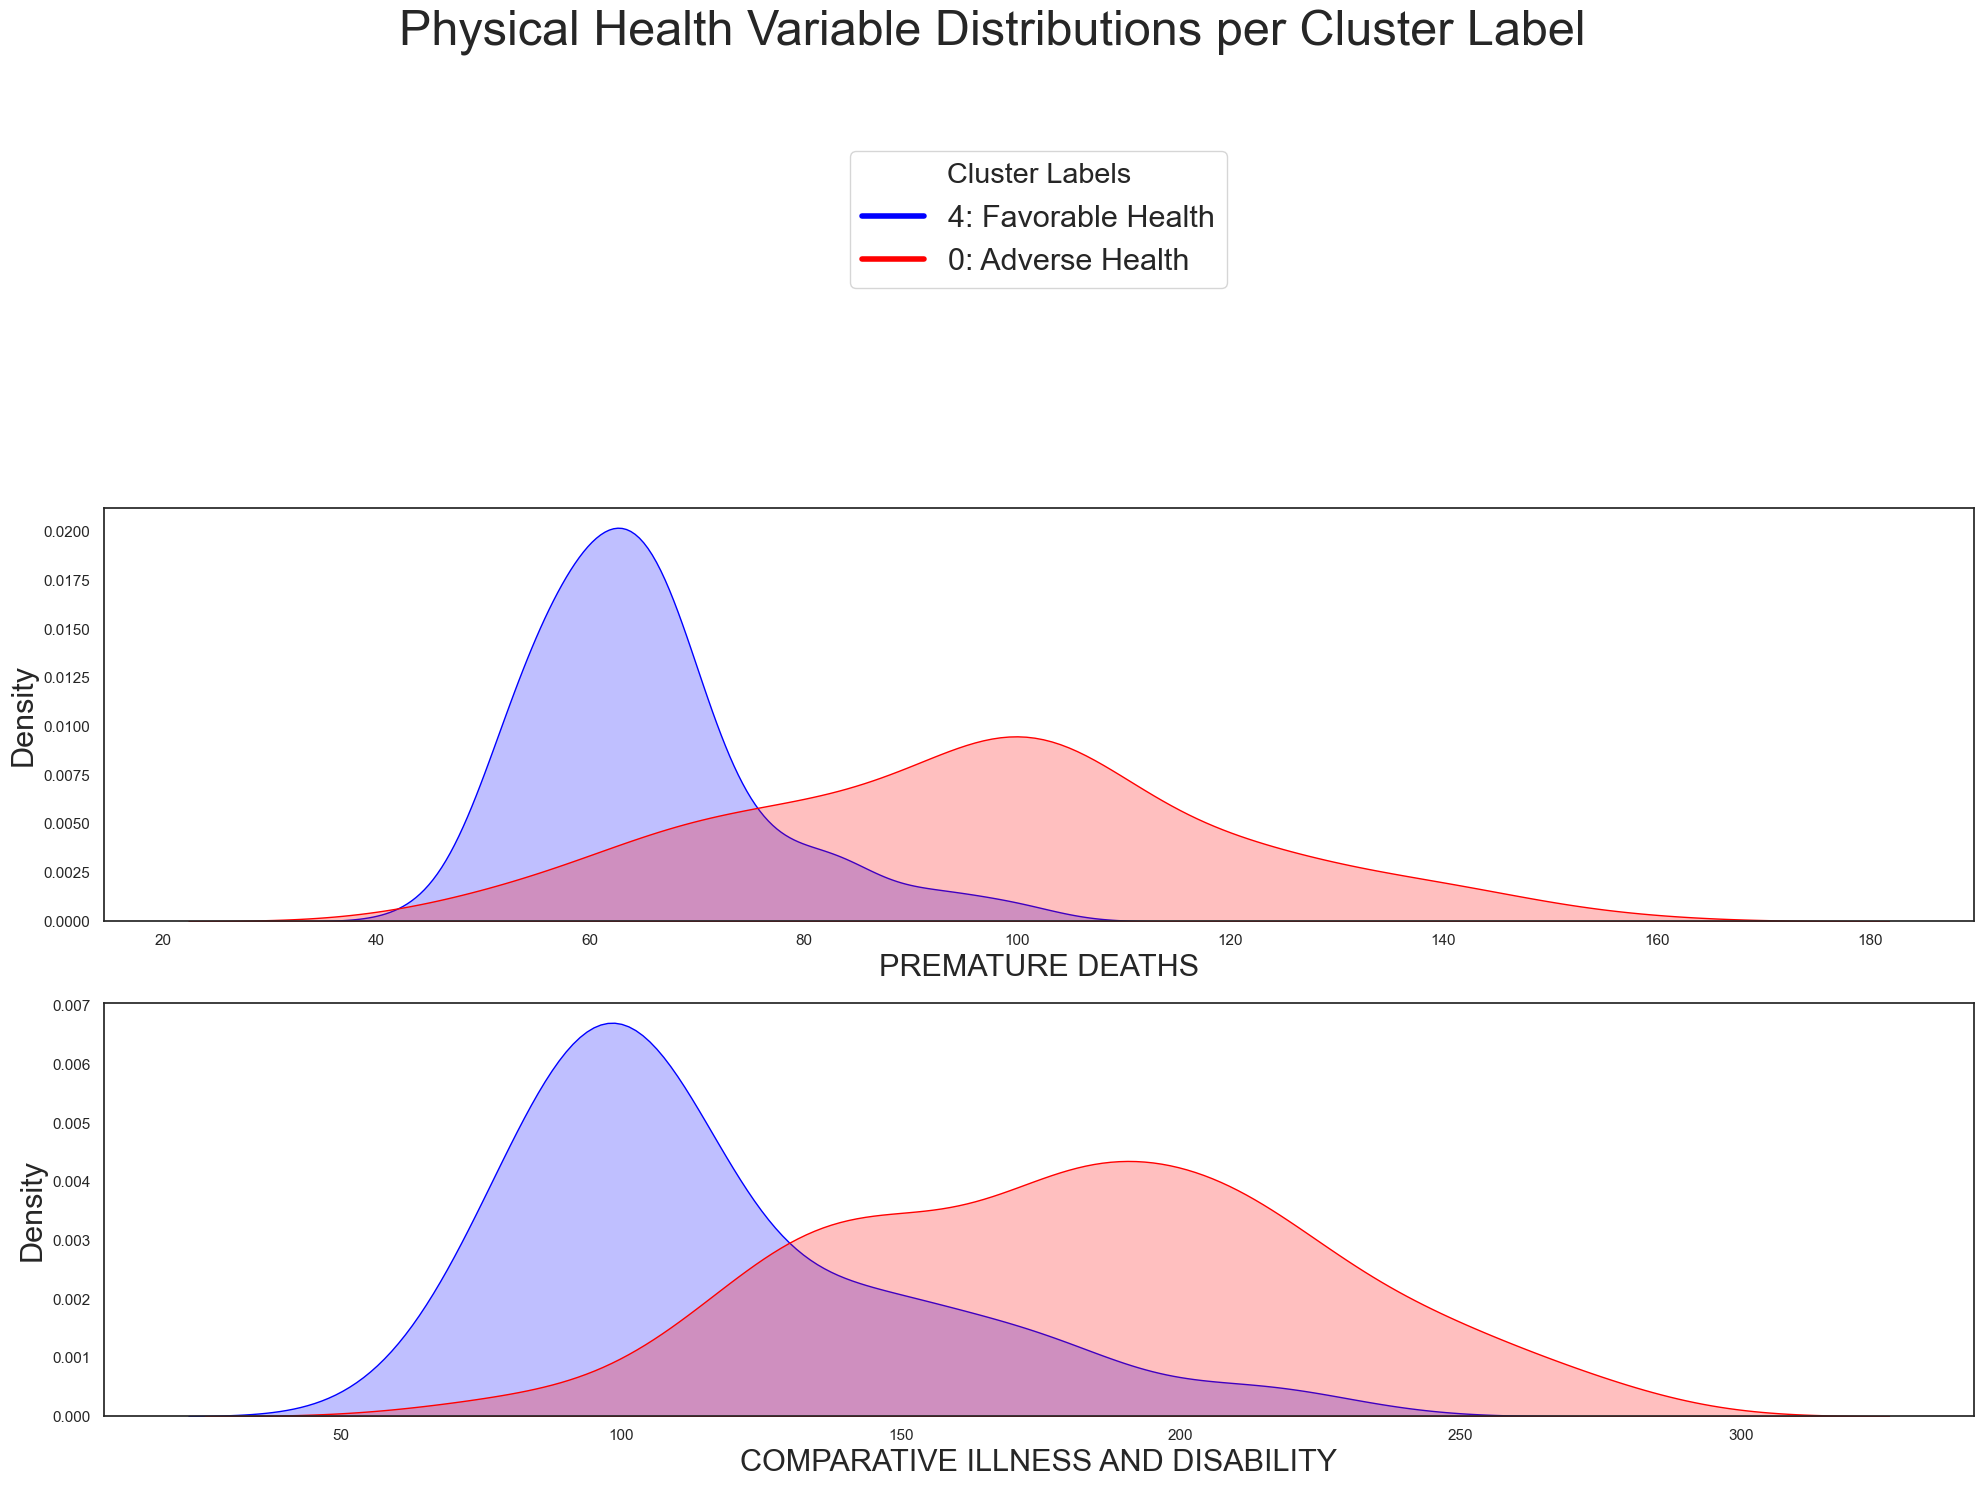

In [62]:
# checking density plots of the mental health variables within these clusters

# cluster variables
variables = ["Premature Deaths",
            "Comparative Illness and Disability"]

# Filter the DataFrame for the desired cluster labels
kmeans_clusters = mentalhealth8[mentalhealth8['Majority Cluster'].isin([4,0])]

# Number of rows for subplots, +1 for the legend
n = len(variables)
nrows = n+1

# Create subplot grid
fig, axes = plt.subplots(nrows=nrows, figsize=(20, nrows*5))

# Flatten axes for iteration
axes = axes.flatten()

# Empty plot for legend
ax = axes[0]
ax.axis('off')

# Create a legend with dummy lines for the first subplot
legend_elements = [Line2D([0], [0], color='blue', lw=4, label='4: Favorable Health'),
                   Line2D([0], [0], color='red', lw=4, label='0: Adverse Health')]
ax.legend(handles=legend_elements, 
          loc='center', 
          title='Cluster Labels', 
          title_fontsize='xx-large', 
          fontsize=22)

# Make cluster 0 be blue and 3 red
color_dict = {4: "blue", 0: "red"}

# For each variable
for i, var in enumerate(variables, start=1):
    ax = axes[i]
    
    # Kernel density plots for each variable
    sb.kdeplot(data=kmeans_clusters, 
               x=var, 
               hue='Majority Cluster', 
               fill=True, palette=color_dict, ax=ax, legend=False)
    ax.set_xlabel(f'{var.upper()}', fontsize=22)
    ax.set_ylabel('Density', fontsize=22)

# Remove empty subplots
for i in range(len(variables)+1, len(axes)):
    fig.delaxes(axes[i])
    
plt.tight_layout()
plt.suptitle("Physical Health Variable Distributions per Cluster Label", y=0.99, fontsize=35)
plt.show()

# Save figure
fig.savefig("healthvardist.png")

### Distributions and descriptive statistics per cluster variable

In [63]:
mentalhealth8.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1679 entries, 0 to 1678
Data columns (total 8 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   ID                                  1679 non-null   int64   
 1   Premature Deaths                    1679 non-null   float64 
 2   Comparative Illness and Disability  1679 non-null   float64 
 3   Income Deprivation                  1679 non-null   float64 
 4   geometry                            1679 non-null   geometry
 5   Ratio of Older Adults               1679 non-null   float64 
 6   Majority Cluster                    1679 non-null   int32   
 7   Cluster Diversity                   1679 non-null   float64 
dtypes: float64(5), geometry(1), int32(1), int64(1)
memory usage: 111.5 KB


In [68]:
# Descriptive statistics per variable
desc_stats = popgridsub.describe()

# Transpose and selecting relevant statistics
desc_stats = desc_stats.T[['count','mean', 'std', 'min', 'max']]

# Rounding to two 
desc_stats = desc_stats.round(2)

print(desc_stats)

                              count      mean        std    min           max
population                 308478.0     12.08      17.71   0.00  1.066000e+03
buffer_pop_density         308478.0   2800.64    2988.56   0.00  2.272525e+04
intersection_count         308478.0    126.46     147.50   1.00  1.821000e+03
street_length_avg          308478.0     81.32      59.29   2.97  1.749760e+03
circuity_avg               308478.0      1.08       0.28   1.00  3.654000e+01
intersection_density_km    308478.0    232.82    2656.74   2.92  1.166170e+06
street_density_km          308478.0  20354.46  569243.60  20.64  3.120593e+08
streets_per_node_counts.2  308478.0      0.43       1.15   0.00  2.700000e+01
streets_per_node_counts.3  308478.0    107.30     112.89   0.00  1.114000e+03
buffer_NDVI_mean           308478.0      0.52       0.15   0.06  8.200000e-01
buffer_LST_mean            308478.0     16.27       1.82  10.14  2.161000e+01
buffer_DEM_mean            308478.0    113.47      85.35  11.49 

In [69]:
# Better visualization
pd.set_option('display.float_format', lambda x: '%.3f' % x)

display(desc_stats)

,count,mean,std,min,max
population,308478.000,12.080,17.710,0.000,1066.000
buffer_pop_density,308478.000,2800.640,2988.560,0.000,22725.250
intersection_count,308478.000,126.460,147.500,1.000,1821.000
street_length_avg,308478.000,81.320,59.290,2.970,1749.760
circuity_avg,308478.000,1.080,0.280,1.000,36.540
intersection_density_km,308478.000,232.820,2656.740,2.920,1166170.060
street_density_km,308478.000,20354.460,569243.600,20.640,312059333.310
streets_per_node_counts.2,308478.000,0.430,1.150,0.000,27.000
streets_per_node_counts.3,308478.000,107.300,112.890,0.000,1114.000
buffer_NDVI_mean,308478.000,0.520,0.150,0.060,0.820


In [70]:
# saving table
desc_stats.to_csv('descriptive_stats.csv')